In [157]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [158]:
import os
'''os.system('pip install wandb google-auth google-auth-oauthlib google-auth-httplib2 protobuf')
os.system('conda update conda')
os.system('conda update python') 
os.system('pip uninstall wandb -y') '''
#os.system('pip install wandb')

"os.system('pip install wandb google-auth google-auth-oauthlib google-auth-httplib2 protobuf')\nos.system('conda update conda')\nos.system('conda update python') \nos.system('pip uninstall wandb -y') "

In [159]:
os.system('python --version')
os.system('wandb --version')

Python 3.10.12
wandb, version 0.15.9


0

In [160]:
import wandb
from wandb.keras import WandbCallback
import os
#os.system('jupyter labextension update --all') #conda update jupyterlab jupyter labextension update --all
#os.system('jupyter labextension list')
os.system('! wandb login be213aaff4ff14945d480abc18697d8664bba8c8')
#wandb.init(project='KaggleAugust2022', name='August2022')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


256

In [161]:
training = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')
test['failure'] = np.NaN
training['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([training,test]) 
#all_data = all_data.dropna()
#all_data = all_data.fillna(np.NaN)
#all_data = all_data.drop(['product_code'], axis=1)
#all_data = all_data.drop(['id'], axis=1)

In [162]:
test

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,train_test
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,NaN,0
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,NaN,0
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,NaN,0
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,NaN,0
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,I,144.74,material_7,material_5,9,5,0,4,9,...,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466,NaN,0
20771,47341,I,74.53,material_7,material_5,9,5,4,8,7,...,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249,NaN,0
20772,47342,I,67.73,material_7,material_5,9,5,10,11,2,...,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349,NaN,0
20773,47343,I,126.15,material_7,material_5,9,5,8,16,11,...,15.422,19.496,9.319,15.817,17.403,16.437,15.179,745.210,NaN,0


In [163]:
all_data

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,train_test
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0.0,1
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0.0,1
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0.0,1
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0.0,1
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,I,144.74,material_7,material_5,9,5,0,4,9,...,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466,NaN,0
20771,47341,I,74.53,material_7,material_5,9,5,4,8,7,...,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249,NaN,0
20772,47342,I,67.73,material_7,material_5,9,5,10,11,2,...,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349,NaN,0
20773,47343,I,126.15,material_7,material_5,9,5,8,16,11,...,15.422,19.496,9.319,15.817,17.403,16.437,15.179,745.210,NaN,0


In [164]:
#one-hot encoding
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
attribute_names = all_data.columns.tolist()
test_atts = test.columns.tolist()
print(attribute_names)
print('----------------------')
print(test_atts)
print(attribute_names == test_atts)

['id', 'product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'failure', 'train_test']
----------------------
['id', 'product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'failure', 'train_test']
True


In [165]:
all_dummies = pd.get_dummies(all_data[attribute_names])
test_dummies = pd.get_dummies(test[test_atts])  
X_train = all_dummies[all_data.train_test == 1].drop(['train_test'], axis=1)
for column in X_train.columns:
    mean_value = X_train[column].mean()
    X_train[column].fillna(mean_value, inplace=True)
X_check = X_train #for heatmap
X_train = X_train.drop(['failure'], axis=1)
X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test==1].failure
X_test = X_test.drop(['failure'], axis=1)
for column in X_test.columns:
    mean_value = X_test[column].mean()
    X_test[column].fillna(mean_value, inplace=True)

'''attr = ohe.fit_transform(all_data.columns).toarray()
X_train = all_dummies[all_data.train_test == 1].drop(['train_test'], axis=1)
X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis=1)'''

def drop_zero_columns(df):
    zero_columns = df.columns[(df == 0).all()]
    df.drop(columns=zero_columns, inplace=True)

#drop_zero_columns(X_train)
#drop_zero_columns(X_test)
#y_train = all_data[all_data.train_test==1].dropna(axis=0).failure
#print(X_test.columns.tolist() == X_train.columns.tolist())

In [166]:
X_train

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,attribute_1_material_8
0,0,80.10,9,5,7,8,4,18.040,12.518000,15.748,...,False,False,False,False,False,True,False,False,False,True
1,1,84.89,9,5,14,3,3,18.213,11.540000,17.717,...,False,False,False,False,False,True,False,False,False,True
2,2,82.43,9,5,12,1,5,18.057,11.652000,16.738,...,False,False,False,False,False,True,False,False,False,True
3,3,101.07,9,5,13,2,6,17.295,11.188000,18.576,...,False,False,False,False,False,True,False,False,False,True
4,4,188.06,9,5,9,2,8,19.346,12.950000,16.990,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,158.95,6,9,6,16,4,16.301,13.259000,18.068,...,False,False,False,False,False,True,False,True,False,False
26566,26566,146.02,6,9,10,12,8,17.543,11.731988,17.984,...,False,False,False,False,False,True,False,True,False,False
26567,26567,115.62,6,9,1,10,1,15.670,11.535000,16.778,...,False,False,False,False,False,True,False,True,False,False
26568,26568,106.38,6,9,2,9,4,18.059,11.731988,16.918,...,False,False,False,False,False,True,False,True,False,False


In [167]:
test

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,train_test
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,NaN,0
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,NaN,0
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,NaN,0
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,NaN,0
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,I,144.74,material_7,material_5,9,5,0,4,9,...,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466,NaN,0
20771,47341,I,74.53,material_7,material_5,9,5,4,8,7,...,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249,NaN,0
20772,47342,I,67.73,material_7,material_5,9,5,10,11,2,...,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349,NaN,0
20773,47343,I,126.15,material_7,material_5,9,5,8,16,11,...,15.422,19.496,9.319,15.817,17.403,16.437,15.179,745.210,NaN,0


In [168]:
training

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,train_test
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,1
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,1
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,1
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,1
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,E,158.95,material_7,material_6,6,9,6,16,4,...,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0,1
26566,26566,E,146.02,material_7,material_6,6,9,10,12,8,...,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0,1
26567,26567,E,115.62,material_7,material_6,6,9,1,10,1,...,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0,1
26568,26568,E,106.38,material_7,material_6,6,9,2,9,4,...,17.064,17.814,14.928,16.273,15.485,13.624,12.865,730.156,0,1


In [169]:
X_test

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,attribute_1_material_8
0,26570,119.57,6,4,6,9,6,19.305,10.178000,17.534,...,True,False,False,False,True,False,False,True,False,False
1,26571,113.51,6,4,11,8,0,17.883,11.927000,17.228,...,True,False,False,False,True,False,False,True,False,False
2,26572,112.16,6,4,8,12,4,18.475,10.481000,16.619,...,True,False,False,False,True,False,False,True,False,False
3,26573,112.72,6,4,8,11,10,16.518,10.888000,15.293,...,True,False,False,False,True,False,False,True,False,False
4,26574,208.00,6,4,14,16,8,17.808,12.693000,17.678,...,True,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,144.74,9,5,0,4,9,18.465,12.570000,18.146,...,False,False,False,True,False,True,True,False,False,False
20771,47341,74.53,9,5,4,8,7,18.900,9.896000,18.288,...,False,False,False,True,False,True,True,False,False,False
20772,47342,67.73,9,5,10,11,2,18.656,11.727331,18.242,...,False,False,False,True,False,True,True,False,False,False
20773,47343,126.15,9,5,8,16,11,16.536,11.226000,18.144,...,False,False,False,True,False,True,True,False,False,False


In [170]:
print(X_test.isna().sum())

id                        0
loading                   0
attribute_2               0
attribute_3               0
measurement_0             0
measurement_1             0
measurement_2             0
measurement_3             0
measurement_4             0
measurement_5             0
measurement_6             0
measurement_7             0
measurement_8             0
measurement_9             0
measurement_10            0
measurement_11            0
measurement_12            0
measurement_13            0
measurement_14            0
measurement_15            0
measurement_16            0
measurement_17            0
product_code_A            0
product_code_B            0
product_code_C            0
product_code_D            0
product_code_E            0
product_code_F            0
product_code_G            0
product_code_H            0
product_code_I            0
attribute_0_material_5    0
attribute_0_material_7    0
attribute_1_material_5    0
attribute_1_material_6    0
attribute_1_material

In [171]:
X_atts = X_train.drop(['id', 'loading', #'failure', 
                       'product_code_A',
                       'product_code_B', 'product_code_C', 'product_code_D', 
                       'product_code_E', 
                       'attribute_0_material_5', 'attribute_0_material_7', 
                                      'attribute_1_material_5', 'attribute_1_material_6', 'attribute_1_material_8'],axis=1)
all_attributes = X_atts.columns.tolist()

In [172]:
#feature engineering
#since the correlation of the data is very low almost everywhere and the names are unspecific,
#we cant really drop anything so I will just do some basic normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler
'''columns_to_normalize = ['measurement_0', 'measurement_1', 'measurement_2', 
                        'measurement_3', 'measurement_4', 'measurement_5', 
                        'measurement_6', 'measurement_7', 'measurement_8', 
                        'measurement_9', 'measurement_10', 'measurement_11', 
                        'measurement_12', 'measurement_13', 'measurement_14', 
                        'measurement_15', 'measurement_16', 'measurement_17']'''
columns_to_normalize = all_attributes
scaler = MinMaxScaler()
X_train_scaled = X_train
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
#X_train_scaled = X_train_scaled[:,~np.all(np.isnan(d), axis=0)]
X_test_scaled = X_test
X_test_scaled[columns_to_normalize] = scaler.fit_transform(X_test[columns_to_normalize])
#X_test_scaled = X_test_scaled.dropna()

In [173]:
X_train

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,attribute_1_material_8
0,0,80.10,1.00,0.0,0.241379,0.275862,0.166667,0.540698,0.532091,0.392964,...,0.0,0.0,0.0,0.0,False,True,False,False,0.0,True
1,1,84.89,1.00,0.0,0.482759,0.103448,0.125000,0.563670,0.416706,0.603507,...,0.0,0.0,0.0,0.0,False,True,False,False,0.0,True
2,2,82.43,1.00,0.0,0.413793,0.034483,0.208333,0.542956,0.429920,0.498824,...,0.0,0.0,0.0,0.0,False,True,False,False,0.0,True
3,3,101.07,1.00,0.0,0.448276,0.068966,0.250000,0.441774,0.375177,0.695359,...,0.0,0.0,0.0,0.0,False,True,False,False,0.0,True
4,4,188.06,1.00,0.0,0.310345,0.068966,0.333333,0.714115,0.583058,0.525770,...,0.0,0.0,0.0,0.0,False,True,False,False,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,158.95,0.25,1.0,0.206897,0.551724,0.166667,0.309786,0.619514,0.641039,...,0.0,0.0,0.0,0.0,False,True,False,True,0.0,False
26566,26566,146.02,0.25,1.0,0.344828,0.413793,0.333333,0.474705,0.439357,0.632057,...,0.0,0.0,0.0,0.0,False,True,False,True,0.0,False
26567,26567,115.62,0.25,1.0,0.034483,0.344828,0.041667,0.225999,0.416116,0.503101,...,0.0,0.0,0.0,0.0,False,True,False,True,0.0,False
26568,26568,106.38,0.25,1.0,0.068966,0.310345,0.166667,0.543221,0.439357,0.518071,...,0.0,0.0,0.0,0.0,False,True,False,True,0.0,False


In [174]:
y_train

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
26565    0.0
26566    0.0
26567    0.0
26568    0.0
26569    0.0
Name: failure, Length: 26570, dtype: float64

In [175]:
y_train.sum()

5649.0

In [176]:
X_test_scaled

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,attribute_1_material_8
0,26570,119.57,0.0,0.0,0.200000,0.272727,0.214286,0.733640,0.339119,0.561906,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
1,26571,113.51,0.0,0.0,0.366667,0.242424,0.000000,0.551892,0.551402,0.529580,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
2,26572,112.16,0.0,0.0,0.266667,0.363636,0.142857,0.627556,0.375895,0.465244,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
3,26573,112.72,0.0,0.0,0.266667,0.333333,0.357143,0.377428,0.425294,0.325164,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
4,26574,208.00,0.0,0.0,0.466667,0.484848,0.285714,0.542306,0.644374,0.577118,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,144.74,1.0,0.2,0.000000,0.121212,0.321429,0.626278,0.629445,0.626558,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False
20771,47341,74.53,1.0,0.2,0.133333,0.242424,0.250000,0.681876,0.304891,0.641559,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False
20772,47342,67.73,1.0,0.2,0.333333,0.333333,0.071429,0.650690,0.527167,0.636700,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False
20773,47343,126.15,1.0,0.2,0.266667,0.484848,0.392857,0.379729,0.466319,0.626347,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False


In [177]:
X_test

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,attribute_1_material_8
0,26570,119.57,0.0,0.0,0.200000,0.272727,0.214286,0.733640,0.339119,0.561906,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
1,26571,113.51,0.0,0.0,0.366667,0.242424,0.000000,0.551892,0.551402,0.529580,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
2,26572,112.16,0.0,0.0,0.266667,0.363636,0.142857,0.627556,0.375895,0.465244,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
3,26573,112.72,0.0,0.0,0.266667,0.333333,0.357143,0.377428,0.425294,0.325164,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
4,26574,208.00,0.0,0.0,0.466667,0.484848,0.285714,0.542306,0.644374,0.577118,...,1.0,0.0,0.0,0.0,True,False,False,True,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,144.74,1.0,0.2,0.000000,0.121212,0.321429,0.626278,0.629445,0.626558,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False
20771,47341,74.53,1.0,0.2,0.133333,0.242424,0.250000,0.681876,0.304891,0.641559,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False
20772,47342,67.73,1.0,0.2,0.333333,0.333333,0.071429,0.650690,0.527167,0.636700,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False
20773,47343,126.15,1.0,0.2,0.266667,0.484848,0.392857,0.379729,0.466319,0.626347,...,0.0,0.0,0.0,1.0,False,True,True,False,0.0,False


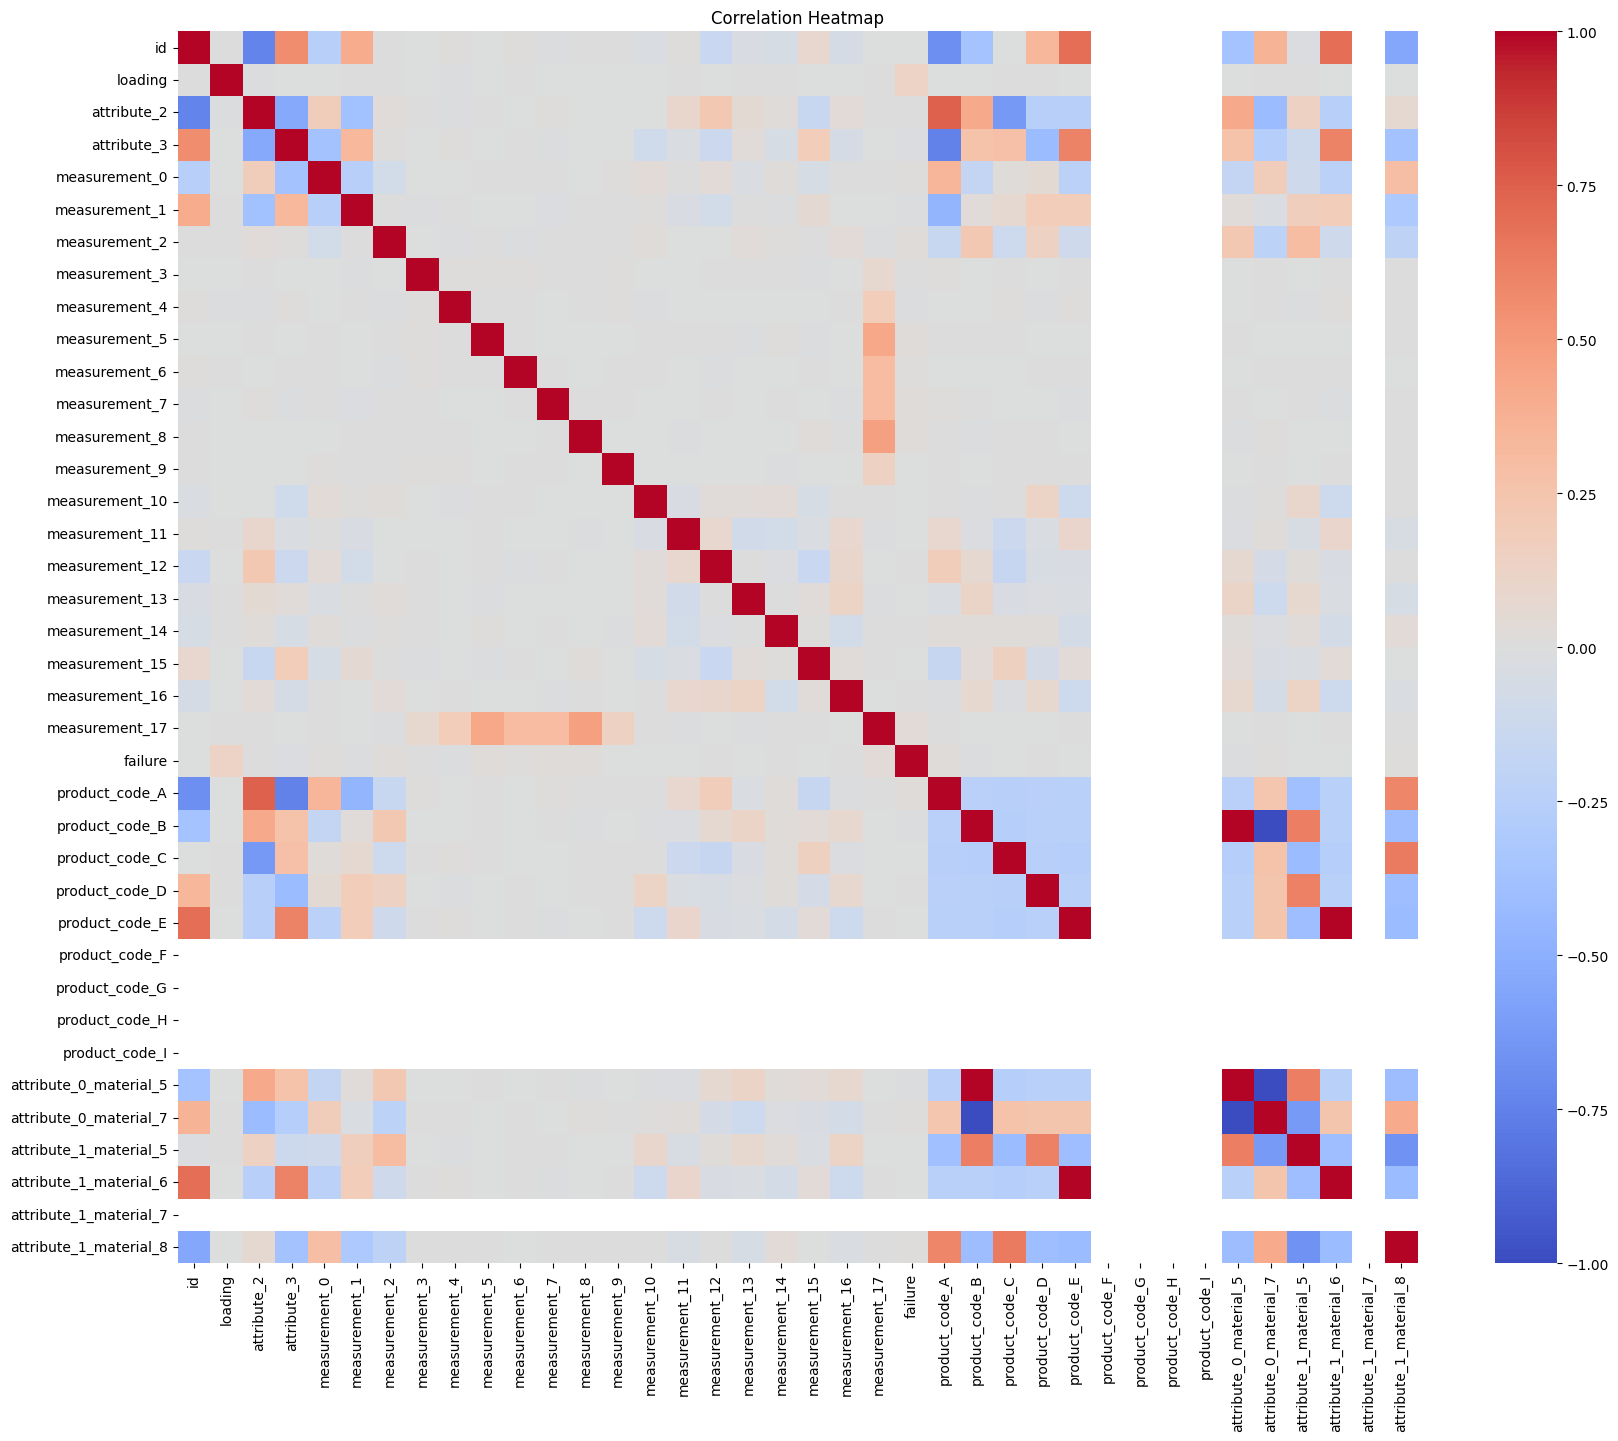

In [178]:
plt.figure(figsize=(20, 16))
#check_A = X_check.drop(['product_code_B', 'product_code_C', 'product_code_D', 'product_code_E'], axis=1)
sns.heatmap(X_check.corr(), annot=False, cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.show()

In [179]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
#from sklearn.model_selection import KFold
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier



In [182]:
print(X_train_scaled.isna().sum())
print(y_train.isna().sum())
print(X_test_scaled.isna().sum())

id                        0
loading                   0
attribute_2               0
attribute_3               0
measurement_0             0
measurement_1             0
measurement_2             0
measurement_3             0
measurement_4             0
measurement_5             0
measurement_6             0
measurement_7             0
measurement_8             0
measurement_9             0
measurement_10            0
measurement_11            0
measurement_12            0
measurement_13            0
measurement_14            0
measurement_15            0
measurement_16            0
measurement_17            0
product_code_A            0
product_code_B            0
product_code_C            0
product_code_D            0
product_code_E            0
product_code_F            0
product_code_G            0
product_code_H            0
product_code_I            0
attribute_0_material_5    0
attribute_0_material_7    0
attribute_1_material_5    0
attribute_1_material_6    0
attribute_1_material

In [183]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
#since the data is very imbalanced I decided to use SMOT
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [184]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#untuned ´models
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print('gnb')
print(cv)
print(cv.mean())
print('#######################')
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print('lr not scaled')
print(cv)
print(cv.mean())
print('#######################')
'''lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print('lr scaled')
print(cv)
print(cv.mean())'''
print('#######################')
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print('dt not scaled')
print(cv)
print(cv.mean())
print('#######################')
'''dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print('dt scaled')
print(cv)
print(cv.mean())
print('#######################')'''
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print('knn not scaled')
print(cv)
print(cv.mean())
print('#######################')
'''knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print('knn scaled')
print(cv)
print(cv.mean())
print('#######################')'''
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print('rf not scaled')
print(cv)
print(cv.mean())
print('#######################')
'''rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print('rf scaled')
print(cv)
print(cv.mean())'''
print('#######################')
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print('svc')
print(cv)
print(cv.mean())
print('#######################')
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train,y_train,cv=5)
print('xgboost')
print(cv)
print(cv.mean())
print('#######################')
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
#voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 
voting_clf = VotingClassifier(estimators = [('dt',dt),('gnb',gnb),('xgb',xgb)], voting = 'soft') 

gnb
[0.16764249 0.08734616 0.22406788 0.11699331 0.09512428]
0.13823482340706061
#######################
lr not scaled
[0.24566854 0.17756004 0.21092256 0.21916826 0.20578394]
0.21182066853294285
#######################
#######################
dt not scaled
[0.193691   0.35978014 0.47813098 0.49390535 0.47227533]
0.39955656139714374
#######################
knn not scaled
[0.47652049 0.46504959 0.4835086  0.48924474 0.4832696 ]
0.47951860492160475
#######################
rf not scaled
[0.23909667 0.35966065 0.47848948 0.48900574 0.47789197]
0.4088289015937218
#######################
#######################
svc
[0.29035727 0.33373163 0.42172562 0.42196463 0.40929732]
0.37541529424236353
#######################
xgboost
[0.14780738 0.32835464 0.49725143 0.5126673  0.49749044]
0.3967142408693469
#######################


In [186]:
print("voting classifier:")
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())
#voting_clf.fit(X_train_scaled,y_train)


voting classifier:
[0.14756841 0.33122237 0.48255258 0.4958174  0.47108031]
0.385648212457565


In [188]:
#other attempts for classifiers
print('####1####') #best so far
voting_clf_1 = VotingClassifier(estimators = [('gnb',gnb),('lr',lr), ('svc',svc)], voting = 'soft')
cv_1 = cross_val_score(voting_clf_1,X_train,y_train,cv=5)
print(cv_1)
print(cv_1.mean())

print('####2####')
voting_clf_2 = VotingClassifier(estimators = [('dt',dt),('xgb',xgb)], voting = 'soft')
cv_2 = cross_val_score(voting_clf_2,X_train,y_train,cv=5)
print(cv_2)
print(cv_2.mean())

print('####3####')
voting_clf_3 = VotingClassifier(estimators = [('dt',dt),('gnb',gnb)], voting = 'soft')
cv_3 = cross_val_score(voting_clf_3,X_train,y_train,cv=5)
print(cv_3)
print(cv_3.mean())

print('####4####')
voting_clf_4 = VotingClassifier(estimators = [('lr',lr), ('dt',dt),('gnb',gnb),('xgb',xgb)], voting = 'soft')
cv_4 = cross_val_score(voting_clf_4,X_train,y_train,cv=5)
print(cv_4)
print(cv_4.mean())

print('####5####')
voting_clf_5 = VotingClassifier(estimators = [('lr',lr), ('dt',dt),('gnb',gnb),('xgb',xgb)], voting = 'hard')
cv_5 = cross_val_score(voting_clf_5,X_train,y_train,cv=5)
print(cv_5)
print(cv_5.mean())
print('####6####') #most promising 
voting_clf_6 = VotingClassifier(estimators = [('gnb',gnb),('lr',lr), ('svc',svc),('xgb',xgb)], voting = 'soft')
cv_6 = cross_val_score(voting_clf_6,X_train,y_train,cv=5)
print(cv_6)
print(cv_6.mean())

####1####
[0.16823993 0.1193691  0.27868069 0.12332696 0.1166348 ]
0.16125029615121084
####2####
[0.193691   0.35978014 0.47813098 0.49390535 0.47227533]
0.39955656139714374
####3####
[0.193691   0.35978014 0.47813098 0.49390535 0.47227533]
0.39955656139714374
####4####
[0.14756841 0.33122237 0.48207457 0.49533939 0.47036329]
0.3853136044269722
####5####
[0.16812044 0.1591588  0.26840344 0.21845124 0.20052581]
0.20293194839280995
####6####
[0.16596965 0.25701995 0.42686424 0.35671606 0.35599904]
0.31251379087943376


####1####
[0.74614227 0.78678961 0.78735416 0.78641325 0.78735416]
0.7788106887467068
####2####
[0.21245766 0.74651863 0.65280391 0.23447497 0.71471584]
0.5121942039894618
####3####
[0.21245766 0.74651863 0.65280391 0.23447497 0.71471584]
0.5121942039894618
####4####
[0.21245766 0.78227324 0.78039142 0.24124953 0.78735416]
0.5607452013549116
####5####
[0.25818592 0.78660143 0.78716598 0.76759503 0.78735416]
0.6773805043281896

In [ ]:
X_train_scaled

In [ ]:
voting_clf.fit(X_train,y_train)
voting_clf_1.fit(X_train,y_train)
voting_clf_2.fit(X_train,y_train)
voting_clf_3.fit(X_train,y_train)
voting_clf_4.fit(X_train,y_train)
voting_clf_5.fit(X_train,y_train)
voting_clf_6.fit(X_train,y_train)
y_hat_base_vc = voting_clf_2.predict(X_test).astype(float)

submission = {'id': test.id , 'failure': y_hat_base_vc}
submission = pd.DataFrame(data=submission)
submission.to_csv('submission.csv', index=False)

In [193]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

#temp
'''gnb = GaussianNB()

lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'LR')

svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

#param_grid = {'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__splitter': 'random', 'learning_rate': 0.0001, 'n_estimators': 1}

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'gamma': ['auto', 0.1, 1], #scale
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 1.0],
}
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

xgb = XGBClassifier(random_state =1)
param_grid = {'colsample_bytree': [0.85, 0.75], 'gamma': [2, 3], 'learning_rate': [0.5], 'max_depth': [None], 
 'min_child_weight': [0.01], 'n_estimators': [500,550], 'reg_alpha': [1], 'reg_lambda': [5,7,10], 
 'sampling_method': ['uniform'], 'subsample': [0.6,0.65]}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')'''
'''#Lr
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'LR')
#KNN

param_grid = {'n_neighbors' : [3,5,7,9,6,8,10,12,14,16,18,20],
              'weights' : ['uniform', 'distance'],
              'leaf_size':list(range(1,50,5)),
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}

knn = KNeighborsClassifier()
clf_knn = GridSearchCV(knn, param_grid= param_grid, cv = 5,scoring = "roc_auc",verbose=1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

#SVC 
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

#RF
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,350,300], #was [400,450,500,550]
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 10, 5], #was 15, 20, 25
                                  'max_features': ['sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}

clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'RF')

#xgb
xgb = XGBClassifier(random_state =1)
param_grid = {'colsample_bytree': [0.85, 0.75], 'gamma': [2, 3], 'learning_rate': [0.5], 'max_depth': [None], 
 'min_child_weight': [0.01], 'n_estimators': [500,550], 'reg_alpha': [1], 'reg_lambda': [5,7,10], 
 'sampling_method': ['uniform'], 'subsample': [0.6,0.65]}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

#dt
dt = tree.DecisionTreeClassifier(random_state = 1)

adaDT = AdaBoostClassifier(dt, random_state=7)

param_grid = {"estimator__criterion" : ["gini", "entropy"],
              "estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

clf_dt = GridSearchCV(adaDT, param_grid = param_grid, cv = 5, verbose = True, scoring="accuracy",n_jobs = -1)
best_clf_dt = clf_dt.fit(X_train_scaled,y_train)
clf_performance(best_clf_dt,'DT')'''

'#Lr\nlr = LogisticRegression()\nparam_grid = {\'max_iter\' : [2000],\n              \'penalty\' : [\'l1\', \'l2\'],\n              \'C\' : np.logspace(-4, 4, 20),\n              \'solver\' : [\'liblinear\']}\n\nclf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)\nbest_clf_lr = clf_lr.fit(X_train_scaled,y_train)\nclf_performance(best_clf_lr,\'LR\')\n#KNN\n\nparam_grid = {\'n_neighbors\' : [3,5,7,9,6,8,10,12,14,16,18,20],\n              \'weights\' : [\'uniform\', \'distance\'],\n              \'leaf_size\':list(range(1,50,5)),\n              \'algorithm\' : [\'auto\', \'ball_tree\',\'kd_tree\'],\n              \'p\' : [1,2]}\n\nknn = KNeighborsClassifier()\nclf_knn = GridSearchCV(knn, param_grid= param_grid, cv = 5,scoring = "roc_auc",verbose=1)\nbest_clf_knn = clf_knn.fit(X_train_scaled,y_train)\nclf_performance(best_clf_knn,\'KNN\')\n\n#SVC \nsvc = SVC(probability = True)\nparam_grid = tuned_parameters = [{\'kernel\': [\'rbf\'], \'gamma\': [.1,.5,1

In [194]:
'''best_lr = best_clf_lr.best_estimator_
#best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
#best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_
#best_dt = best_clf_dt.best_estimator_

feat_importances = pd.Series(best_lr.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

#feat_importances = pd.Series(best_knn.feature_importances_, index=X_train_scaled.columns)
#feat_importances.nlargest(20).plot(kind='barh')

feat_importances = pd.Series(best_svc.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

#feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
#feat_importances.nlargest(20).plot(kind='barh')

feat_importances = pd.Series(best_xgb.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

#feat_importances = pd.Series(best_dt.feature_importances_, index=X_train_scaled.columns)
#feat_importances.nlargest(20).plot(kind='barh')'''

NameError: name 'best_clf_lr' is not defined

In [ ]:
'''estimators = [
    ('dt', best_dt),
    ('mpl', best_mpl),
    ('knn', best_knn),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lr', best_lr),
    ('svc', best_svc),
    ('gpc', best_gpc)
    ('gnb',gnb),
    ('svc',svc)
]
'''
#weights = [2,1,2,2,1,1]

'''voting_clf_1 = VotingClassifier(estimators=estimators, voting='soft')
print('voting_clf_1 :',cross_val_score(voting_clf_1X_train_scaled,y_train,cv=5))
print('voting_clf_1mean :',cross_val_score(voting_clf_1X_train_scaled,y_train,cv=5).mean())

y_hat_vc = voting_clf_1.fit(X_train_scaled, y_train)
y_hat_vc = voting_clf_1.predict(X_test_scaled).astype(int)

submission = {'id': test.id , 'failure': y_hat_vc}
submission = pd.DataFrame(data=submission)
submission.to_csv('submission.csv', index=False)'''

'''voting_clf_6 = VotingClassifier(estimators = [('gnb',gnb),('lr',best_lr), ('svc',best_svc),('xgb',best_xgb)], voting = 'soft')
cv_6 = cross_val_score(voting_clf_6,X_train_scaled,y_train,cv=5)
print(cv_6)
print(cv_6.mean())
y_hat_vc = voting_clf_6.fit(X_train_scaled, y_train)
y_hat_vc = voting_clf_6.predict(X_test_scaled).astype(int)
submission = {'id': test.id , 'failure': y_hat_vc}
submission = pd.DataFrame(data=submission)
submission.to_csv('submission.csv', index=False)'''

In [ ]:
#os.system('pip install --upgrade matplotlib')

In [ ]:
#temp disabled
wandb.init(project='KaggleAugust2022', name='Random State = 1 Voting Classifiers now with new data')


# Define a function to plot learning curves for a given classifier
def plot_learning_curve(classifier, X, y, classifier_name, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(f"Learning Curve for {classifier_name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")

    # Save the plot as an image file
    plt.savefig(f"{classifier_name}_learning_curve.png")

# Assuming you have training data X_train and labels y_train
# You can customize the cross-validation strategy by specifying the 'cv' parameter

# Example usage for multiple classifiers
plot_learning_curve(voting_clf, X_train, y_train, "voting_clf")
plot_learning_curve(voting_clf_1, X_train, y_train, "voting_clf_1")
plot_learning_curve(voting_clf_2, X_train, y_train, "voting_clf_2")
plot_learning_curve(voting_clf_3, X_train, y_train, "voting_clf_3")
plot_learning_curve(voting_clf_1, X_train, y_train, "voting_clf_4")
plot_learning_curve(voting_clf_2, X_train, y_train, "voting_clf_5")
plot_learning_curve(voting_clf_3, X_train, y_train, "voting_clf_6")

# Log the saved images to W&B
wandb.log({"learning_curve": wandb.Image("voting_clf_learning_curve.png")})
wandb.log({"learning_curve_1": wandb.Image("voting_clf_1_learning_curve.png")})
wandb.log({"learning_curve_2": wandb.Image("voting_clf_2_learning_curve.png")})
wandb.log({"learning_curve_3": wandb.Image("voting_clf_3_learning_curve.png")})
wandb.log({"learning_curve_4": wandb.Image("voting_clf_4_learning_curve.png")})
wandb.log({"learning_curve_5": wandb.Image("voting_clf_5_learning_curve.png")})
wandb.log({"learning_curve_6": wandb.Image("voting_clf_6_learning_curve.png")})

# Finish the run
wandb.finish()

In [ ]:
#temp disabled
'''
# Initialize W&B
wandb.init(project='KaggleAugust2022', name='August2022')

# Define a function to extract and log hyperparameters for a given classifier
def log_classifier_hyperparameters(classifier, classifier_name):
    hyperparameters = classifier.get_params()
    wandb.config.update({f"{classifier_name}_hyperparameters": hyperparameters})

# Define a function to plot learning curves for a given classifier
def plot_learning_curve(classifier, X, y, classifier_name, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(f"Learning Curve for {classifier_name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")

    # Save the plot as an image file
    plt.savefig(f"{classifier_name}_learning_curve.png")

    # Log the saved image to W&B
    wandb.log({f"{classifier_name}_learning_curve": wandb.Image(f"{classifier_name}_learning_curve.png")})

hyperparameters = {}
# Define your individual classifiers and their names
classifiers = [
    ('lr', lr),
    ('knn', knn),
    ('rf', rf),
    ('gnb', gnb),
    ('svc', svc),
    ('xgb', xgb),
]

#new
for name, clf in classifiers:
    hyperparameters[name] = clf.get_params()
#end new

# Extract and log hyperparameters and plot learning curves for individual classifiers
for name, clf in classifiers:
    log_classifier_hyperparameters(clf, name)
    plot_learning_curve(clf, X_train, y_train, name)

# Create an ensemble of classifiers (e.g., VotingClassifier)
# Replace the classifiers and their weights as needed for your ensemble
#ensemble = VotingClassifier(classifiers, voting='hard')  # Example VotingClassifier

# Extract and log hyperparameters for the ensemble

all_ens = [voting_clf, voting_clf_1, voting_clf_2, voting_clf_3, voting_clf_4, voting_clf_5, voting_clf_6]

for ens in all_ens:
    log_classifier_hyperparameters(ens, "ToDo")
    plot_learning_curve(ens, X_train, y_train, "ToDo")
    #new
    hyperparameters['ToDo'] = ens.get_params()
    wandb.config.update(hyperparameters)

# Plot and log the learning curve for the ensemble
#plot_learning_curve(ensemble, X_train, y_train, 'ensemble')


# Log hyperparameters to W&B



# Finish the run
wandb.finish()'''



In [ ]:
#temp disabled

'''import plotly.graph_objects as go
from sklearn.model_selection import learning_curve
wandb.init(project='KaggleAugust2022', name='August2022')

def plot_learning_curve(classifier, X, y, classifier_name, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Create an interactive Plotly figure
    fig = go.Figure()

    # Add training score trace
    fig.add_trace(
        go.Scatter(
            x=train_sizes,
            y=train_scores_mean,
            mode="lines+markers",
            name="Training Score",
        )
    )

    # Add cross-validation score trace
    fig.add_trace(
        go.Scatter(
            x=train_sizes,
            y=test_scores_mean,
            mode="lines+markers",
            name="Cross-validation Score",
        )
    )

    # Customize the layout of the plot
    fig.update_layout(
        title=f"Learning Curve for {classifier_name}",
        xaxis_title="Training examples",
        yaxis_title="Score",
    )

    # Log the Plotly plot to W&B
    wandb.log(
        {f"{classifier_name}_learning_curve": wandb.Plotly(fig)},
        {"classifier_name": classifier_name},  # Additional metadata
    )

# Example usage for multiple classifiers
# Replace these with your actual classifiers and data
# Plot and log learning curve for the ensemble


plot_learning_curve(voting_clf, X_train, y_train, "voting_clf")
plot_learning_curve(voting_clf_1, X_train, y_train, "voting_clf_1")
plot_learning_curve(voting_clf_2, X_train, y_train, "voting_clf_2")
plot_learning_curve(voting_clf_3, X_train, y_train, "voting_clf_3")
plot_learning_curve(voting_clf_1, X_train, y_train, "voting_clf_4")
plot_learning_curve(voting_clf_2, X_train, y_train, "voting_clf_5")
plot_learning_curve(voting_clf_3, X_train, y_train, "voting_clf_6")

# Log the saved images to W&B
wandb.log({"learning_curve": wandb.Image("voting_clf_learning_curve.png")})
wandb.log({"learning_curve_1": wandb.Image("voting_clf_1_learning_curve.png")})
wandb.log({"learning_curve_2": wandb.Image("voting_clf_2_learning_curve.png")})
wandb.log({"learning_curve_3": wandb.Image("voting_clf_3_learning_curve.png")})
wandb.log({"learning_curve_4": wandb.Image("voting_clf_4_learning_curve.png")})
wandb.log({"learning_curve_5": wandb.Image("voting_clf_5_learning_curve.png")})
wandb.log({"learning_curve_6": wandb.Image("voting_clf_6_learning_curve.png")})


# Finish the run
wandb.finish()'''

In [ ]:
#fails
'''from sklearn.model_selection import learning_curve

# Initialize W&B
wandb.init(project='KaggleAugust2022', name='August2022')

# Define a function to plot learning curves for a given classifier
def plot_learning_curve(classifier, X, y, classifier_name, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(f"Learning Curve for {classifier_name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")

    # Save the plot as an image file
    plt.savefig(f"{classifier_name}_learning_curve.png")

    # Log the saved image to W&B with hyperparameters
    wandb.log(
        {
            f"{classifier_name}_learning_curve": wandb.Image(f"{classifier_name}_learning_curve.png"),
            f"{classifier_name}_hyperparameters": classifier.get_params(),
        }
    )
    
classifiers = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)]

for name, clf in classifiers:
    log_classifier_hyperparameters(clf, name)
    plot_learning_curve(clf, X_train, y_train, name)

plot_learning_curve(voting_clf, X_train, y_train, "voting_clf")
plot_learning_curve(voting_clf_1, X_train, y_train, "voting_clf_1")
plot_learning_curve(voting_clf_2, X_train, y_train, "voting_clf_2")
plot_learning_curve(voting_clf_3, X_train, y_train, "voting_clf_3")
plot_learning_curve(voting_clf_1, X_train, y_train, "voting_clf_4")
plot_learning_curve(voting_clf_2, X_train, y_train, "voting_clf_5")
plot_learning_curve(voting_clf_3, X_train, y_train, "voting_clf_6")

# Log the saved images to W&B


wandb.finish()'''

In [ ]:
#fails
'''def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")

    # Log the plot to W&B
    wandb.log({"learning_curve": plt})

# Assuming you have training data X_train and labels y_train
# You can customize the cross-validation strategy by specifying the 'cv' parameter
plot_learning_curve(voting_clf, X_train, y_train) #.columns.tolist()

# Finish the run
wandb.finish()'''